In [1]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()

df = pd.read_csv('powerdemand_5min_2021_to_2024_with weather.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Resample and compute daily metrics
daily_df = pd.DataFrame({
    'Total_Demand': df['Power demand'].resample('D').sum(),
    'Peak_Demand': df['Power demand'].resample('D').max(),
    'Temp': df['temp'].resample('D').mean(),
    'Humidity': df['rhum'].resample('D').mean()
})


daily_df['Lag1'] = daily_df['Total_Demand'].shift(1)
daily_df['Lag2'] = daily_df['Total_Demand'].shift(2)
daily_df['Rolling7'] = daily_df['Total_Demand'].rolling(7).mean()
daily_df['Rolling14'] = daily_df['Total_Demand'].rolling(14).mean()
daily_df['Weekday'] = daily_df.index.dayofweek
daily_df['Month'] = daily_df.index.month


daily_df.dropna(inplace=True)

# Preview processed data
daily_df.head()


Saving powerdemand_5min_2021_to_2024_with weather.csv to powerdemand_5min_2021_to_2024_with weather.csv


,Total_Demand,Peak_Demand,Temp,Humidity,Lag1,Lag2,Rolling7,Rolling14,Weekday,Month
datetime,,,,,,,,,,
2021-01-14,931961.87,4781.50,11.225000,82.250000,926888.64,751727.31,997653.897143,9.897221e+05,3,1
2021-01-15,923878.23,4770.78,13.325000,84.833333,931961.87,926888.64,964107.242857,9.901317e+05,4,1
2021-01-16,879139.37,4474.44,10.875000,90.479167,923878.23,931961.87,932978.408571,9.923607e+05,5,1
2021-01-17,890038.21,4612.98,10.120833,90.083333,879139.37,923878.23,868914.161429,1.002818e+06,6,1
2021-01-18,911797.64,4771.47,13.408333,87.708333,890038.21,879139.37,887918.752857,1.006162e+06,0,1


In [3]:
daily_input = daily_df[-30:]
daily_input.to_csv("daily_input.csv", index=False)

from google.colab import files
files.download("daily_input.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_df)

# Set sequence length (last 30 days to predict next day)
SEQ_LEN = 30
X, y = [], []

# Build sequences
for i in range(SEQ_LEN, len(scaled_data)):
    X.append(scaled_data[i-SEQ_LEN:i])
    y.append(scaled_data[i][:2])  # [Total_Demand, Peak_Demand]

X = np.array(X)
y = np.array(y)

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (1102, 30, 10)
X_test shape: (276, 30, 10)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(daily_df)

# Save the fitted scaler
import joblib
joblib.dump(scaler, "scaler.pkl")
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Layer
import tensorflow.keras.backend as K
import keras_tuner as kt

# Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Model Builder Function for Tuning
def model_builder(hp):
    input_layer = Input(shape=(X.shape[1], X.shape[2]))

    # Tune number of LSTM units
    units1 = hp.Int("units1", min_value=64, max_value=256, step=32)
    units2 = hp.Int("units2", min_value=32, max_value=128, step=32)

    x = Bidirectional(LSTM(units1, return_sequences=True))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(units2, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Attention()(x)

    output = Dense(2)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Define tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tune_dir',
    project_name='electricity_demand_forecast'
)

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Start hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Trial 10 Complete [00h 00m 59s]
val_loss: 0.008004776202142239

Best val_loss So Far: 0.007338028866797686
Total elapsed time: 00h 09m 59s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           158 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,632 (537.62 KB)

 Trainable params: 137,632 (537.62 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = best_model.predict(X_test)


pad_pred = np.hstack([y_pred, np.zeros((y_pred.shape[0], scaled_data.shape[1] - 2))])
pad_true = np.hstack([y_test, np.zeros((y_test.shape[0], scaled_data.shape[1] - 2))])

# Inverse transform
y_pred_inv = scaler.inverse_transform(pad_pred)[:, :2]
y_test_inv = scaler.inverse_transform(pad_true)[:, :2]

# Evaluation Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"🔹 R-squared (R2) Score: {r2:.2f}")

# Separate metrics
print("\n🔹 Evaluation for Total Demand:")
print(f"  MAE: {mean_absolute_error(y_test_inv[:, 0], y_pred_inv[:, 0]):.2f}")
print(f"  R2 : {r2_score(y_test_inv[:, 0], y_pred_inv[:, 0]):.2f}")

print("\n🔹 Evaluation for Peak Demand:")
print(f"  MAE: {mean_absolute_error(y_test_inv[:, 1], y_pred_inv[:, 1]):.2f}")
print(f"  R2 : {r2_score(y_test_inv[:, 1], y_pred_inv[:, 1]):.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
🔹 Mean Absolute Error (MAE): 77981.42
🔹 Mean Squared Error (MSE): 20758620601.10
🔹 Root Mean Squared Error (RMSE): 144078.52
🔹 R-squared (R2) Score: 0.70

🔹 Evaluation for Total Demand:
  MAE: 155391.17
  R2 : 0.69

🔹 Evaluation for Peak Demand:
  MAE: 571.67
  R2 : 0.71


Enter start date (dd/mm/yyyy): 22/07/2023
Enter end date (dd/mm/yyyy): 22/09/2023
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

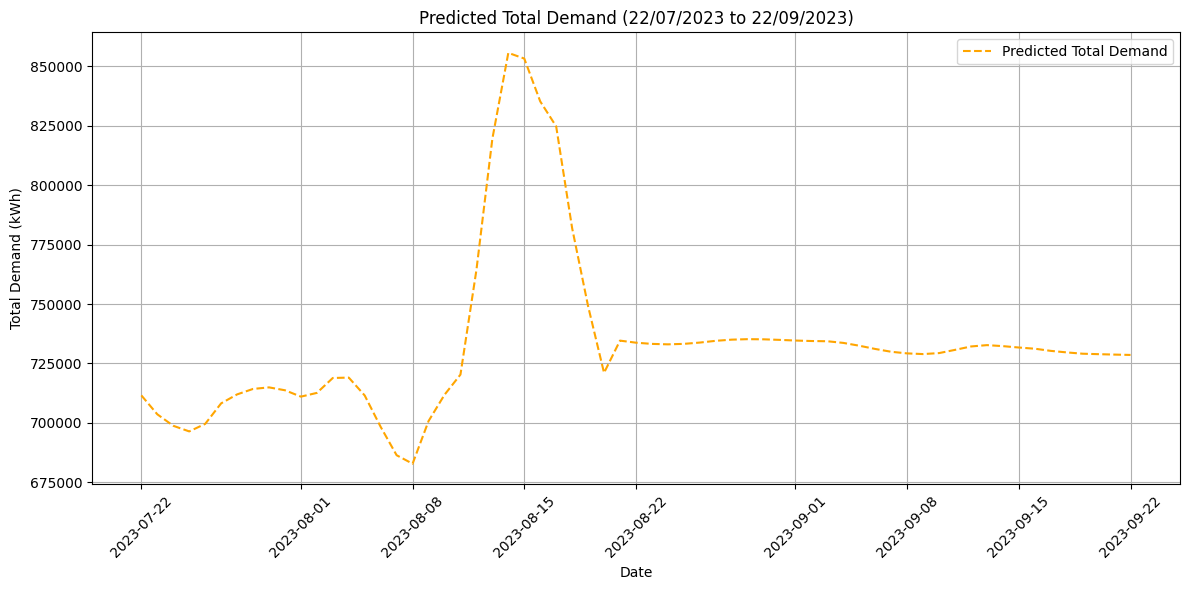

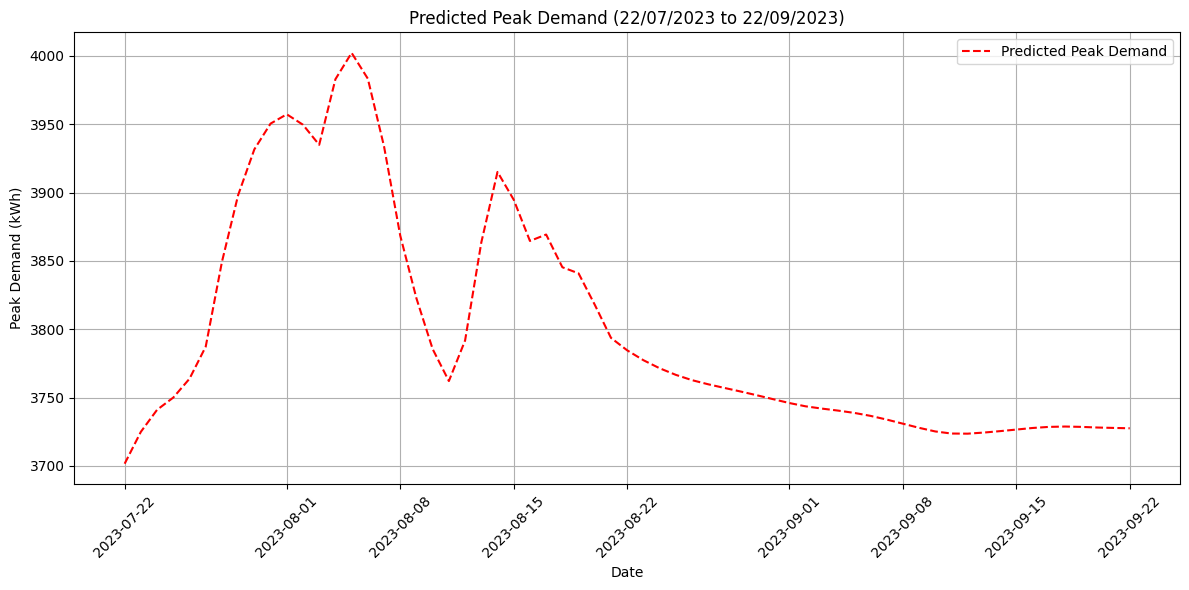

In [9]:
from datetime import datetime, timedelta

# USER DATE INPUT
start_date_str = input("Enter start date (dd/mm/yyyy): ")
end_date_str = input("Enter end date (dd/mm/yyyy): ")

start_date = datetime.strptime(start_date_str, "%d/%m/%Y")
end_date = datetime.strptime(end_date_str, "%d/%m/%Y")
num_days = (end_date - start_date).days + 1

# Use last 30 days for seed input
future_input = scaled_data[-SEQ_LEN:].copy()
future_predictions = []

for _ in range(num_days):
    pred = best_model.predict(future_input.reshape(1, SEQ_LEN, scaled_data.shape[1]))

    next_row = np.zeros((scaled_data.shape[1],))
    next_row[:2] = pred[0]                        # [Total_Demand, Peak_Demand]
    next_row[2:] = future_input[-1, 2:]           # Use last Temp, Humidity, Weekday

    future_input = np.vstack([future_input[1:], next_row])
    future_predictions.append(pred[0])

# Extract Total & Peak
future_predictions = np.array(future_predictions)
future_pad = np.hstack([future_predictions, np.zeros((future_predictions.shape[0], scaled_data.shape[1] - 2))])
future_predictions_inv = scaler.inverse_transform(future_pad)[:, :2]

# Create date index
future_dates = pd.date_range(start=start_date, periods=num_days)

# Plot Total Demand
plt.figure(figsize=(12,6))
plt.plot(future_dates, future_predictions_inv[:, 0], label='Predicted Total Demand', color='orange', linestyle='--')
plt.title(f"Predicted Total Demand ({start_date_str} to {end_date_str})")
plt.xlabel("Date")
plt.ylabel("Total Demand (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Peak Demand
plt.figure(figsize=(12,6))
plt.plot(future_dates, future_predictions_inv[:, 1], label='Predicted Peak Demand', color='red', linestyle='--')
plt.title(f"Predicted Peak Demand ({start_date_str} to {end_date_str})")
plt.xlabel("Date")
plt.ylabel("Peak Demand (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
best_model.save("best_electricity_model.h5")


In [11]:
from google.colab import files
files.download("best_electricity_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>